In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


## Связь между $\alpha$, $\beta$, MDE

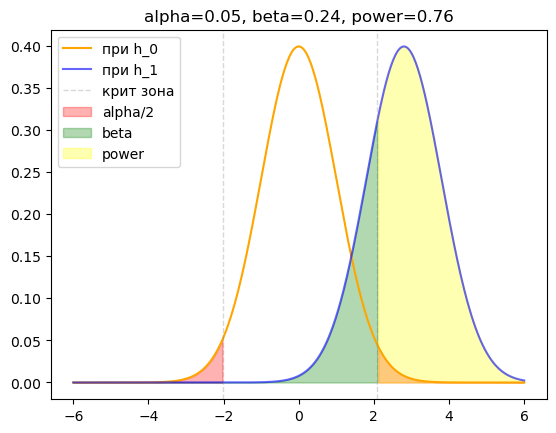

In [ ]:
mu = 0
sigma = 1
effect = 2.8
alpha = 0.05
beta = 0.2

x = np.linspace(-6, 6, 400)

h_0 = stats.norm(loc=mu, scale=sigma)
h_1 = stats.norm(loc=mu+effect, scale=sigma)
s = np.random.normal(mu, sigma, 1000)

#графики при h
plt.plot(x, h_0.pdf(x), label='при h_0', color='orange')
plt.plot(x, h_1.pdf(x), label='при h_1', color='blue', alpha=.6)


#лева критическая область
alpha_q = np.percentile(s, alpha/2*100)
x_fill = x[x <= alpha_q]
plt.axvline(alpha_q, label='крит зона', color='grey', alpha=.3, linewidth=1, ls='--')
plt.fill_between(x_fill, h_0.pdf(x_fill), 0, label='alpha/2', alpha=.3, color='red')

#правая критическая область
alpha_q = np.percentile(s, (1-alpha/2)*100)
x_fill = x[x >= alpha_q]
plt.fill_between(x_fill, h_0.pdf(x_fill), 0, alpha=.3, color='red')
plt.axvline(alpha_q, color='grey', alpha=.3, linewidth=1, ls='--')

x_fill = x[x <= alpha_q]
plt.fill_between(x_fill, h_1.pdf(x_fill), 0, label='beta', alpha=.3, color='green')
x_fill = x[x >= alpha_q]
plt.fill_between(x_fill, h_1.pdf(x_fill), 0, label='power', alpha=.3, color='yellow')

alpha_print = round(h_0.cdf(h_0.ppf(alpha/2)) + 1-h_0.cdf(h_0.ppf(1-alpha/2)), 3)
beta = round(h_1.cdf(np.percentile(s, (1-alpha/2)*100)),2)
power = round(1-beta, 3)

plt.title(f'alpha={alpha_print}, beta={round(beta, 3)}, power={power}')
plt.legend()

## Доверительные интервалы

0.548089289087356

## Дисперсия дельта-методом

## Тест Манна — Уитни

## Тест Колмогорова-Смирнова